## 講習5 --- IRAF.APPHOTと結果の可視化

IRAFのapphotで点光源の測光をします。そしてその結果を可視化します。

### IRAF.APPHOT
まずは必要なモジュールをimportします。 そしてIRAFのパラメータを初期化しておきます。

In [1]:
from pyraf import iraf
from iraf import noao
from iraf import digiphot
from iraf import apphot
import pyfits
import numpy as np

iraf.apphot.unlearn()
iraf.daofind.unlearn()
iraf.txdump.unlearn()

In [2]:
targetfits = './010604.ffiles/hf0001.fits'

バックグラウンドのmedianとノイズの評価をします。  

In [3]:
iraf.imstat.unlearn()
iraf.imstat.fields = 'midpt, stddev'
iraf.imstat.lower = 0
iraf.imstat.upper = 20000
iraf.imstat.nclip = 5
iraf.imstat.format = 'no'  #  ヘッダ行なし
iraf.imstat.cache = 'yes'

In [4]:
statout = iraf.imstat(targetfits, Stdout=1)  
v = statout[0].split()
med = float(v[0])
stddev = float(v[1])
print (med, stddev)

1057.796 13.91935


IRAFのタスクのパラメータを設定します。  

In [5]:
iraf.apphot.datapars.datamax = 20000
iraf.apphot.datapars.readnoise = 30
iraf.apphot.datapars.epadu = 5
iraf.apphot.datapars.itime = 20
iraf.apphot.fitskypars.dannulus = 5.
iraf.apphot.findpars.threshold = 10
iraf.apphot.findpars.sharphi = 0.8

iraf.apphot.daofind.output = 'ap.coo' # daofindの結果はこの名前のファイルに
iraf.apphot.daofind.interac = 'no'
iraf.apphot.daofind.verify = 'no'

iraf.apphot.phot.interactive = 'no'
iraf.apphot.phot.verify = 'no'
iraf.apphot.phot.verbose = 'no'
iraf.apphot.photpars.zmag = 21

ifwhm = 3
iraf.apphot.datapars.fwhmpsf = ifwhm
iraf.apphot.centerpars.cbox = max(5.0, ifwhm)
iraf.apphot.fitskypars.annulus = 3 * ifwhm
iraf.apphot.photpars.apertures = 3 * ifwhm

iraf.apphot.findpars.threshold = 10
iraf.apphot.datapars.sigma = stddev
iraf.apphot.datapars.datamin = med - 5 * stddev

In [6]:
iraf.daofind(targetfits)
iraf.phot(targetfits, coords='ap.coo', output='ap.mag')  # apphotの結果をファイル'ap.mag'に
mlim = 0.15  # merr < 0.15 のものだけ
iraf.txdump('ap.mag', fields='xc,yc,mag,merr', expr='merr<'+str(mlim), Stdout='coo.txt')  
# 'ap.mag'の中から必要な項目だけを抽出してファイル'coo.txt'に

In [7]:
cat 'coo.txt'

398.061  20.904  14.855  0.054
162.722  46.646  15.570  0.113
819.673  57.529  15.595  0.107
877.487  61.928  13.439  0.017
503.896  66.586  15.643  0.119
503.005  69.902  15.741  0.124
322.946  80.235  14.655  0.048
351.021  92.790  15.913  0.141
492.617  104.203  15.028  0.066
532.422  105.577  15.935  0.141
584.480  116.065  15.324  0.086
216.529  128.573  15.310  0.087
417.273  128.758  15.811  0.121
32.893  142.345  12.023  0.005
510.587  169.303  14.824  0.055
587.469  178.491  15.504  0.088
221.187  198.359  15.969  0.149
143.589  198.991  14.356  0.035
255.469  218.499  15.380  0.088
35.747  259.467  13.901  0.021
487.693  261.356  15.353  0.086
333.444  271.539  15.730  0.120
642.508  287.236  13.871  0.023
293.383  297.735  14.362  0.036
231.673  339.831  15.892  0.143
900.098  339.549  14.304  0.033
876.014  351.581  15.851  0.139
351.246  360.502  15.583  0.110
268.631  393.988  15.779  0.135
438.121  408.439  15.308  0.084
595.441  434.921  15.951  0.138
550.172  449.957  

光度関数とmag vs. merrプロットを描いてみます。  
numpyのところでやったように、**numpy.loadtxt()**を使ってcoo.txtからデータを読み込みます。

In [8]:
xymag = np.loadtxt('coo.txt')

pythonのインデックスは0から始まることに注意。等級は3カラム目。等級エラーは4カラム目。

In [9]:
mag = xymag[:, 2]
merr = xymag[:, 3]

In [10]:
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt

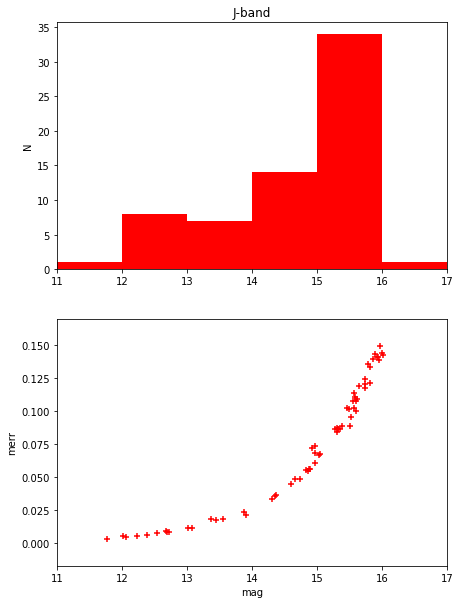

In [12]:
plt.figure(figsize=(7, 10))

plt.subplot(211)
plt.hist(mag, bins=6, range=(11,17), color='red')
plt.xlim(11, 17)
plt.title('J-band')
plt.ylabel('N')

plt.subplot(212)
plt.scatter(mag, merr, marker='+', color='red')
plt.xlim(11, 17)
plt.xlabel('mag')
plt.ylabel('merr')
plt.show()

FITS画像を表示して、測光した星にマークをつけます。  
FITS画像のデータをpyfitsで読み込む時、各ピクセルのインデックスは0から始まります。IRAFのAPPHOTで得られる(x, y)=(1,1)はPYTHONの配列では(0,0)です。 したがって、マークをつける場合には1だけ引いてやる必要があります。

In [13]:
xcoo = xymag[:, 0] - 1
ycoo = xymag[:, 1] - 1

In [14]:
data = pyfits.getdata(targetfits)

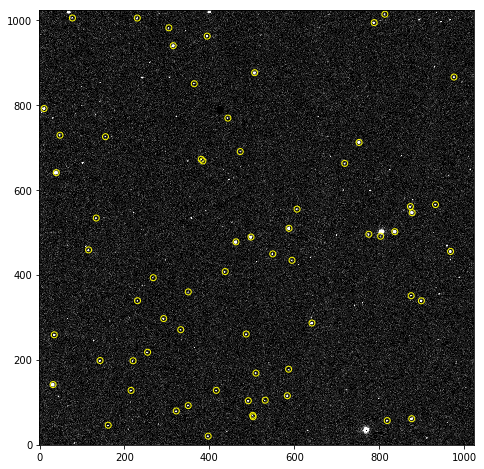

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(data, plt.cm.gray, vmin=med - stddev, vmax = med + 10 * stddev, origin='lower', interpolation='none')
plt.scatter(xcoo, ycoo, edgecolors='yellow', facecolors='none')
plt.show()

適当にスケーリングして、明るさに応じて円の大きさを変えてみる。

In [16]:
plotsize = pow(10, -0.4 * mag) * 1.0e7

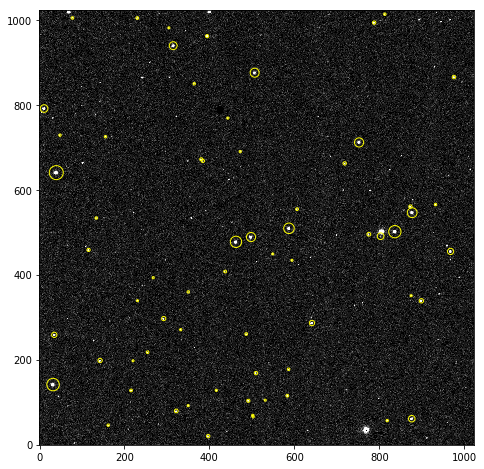

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(data, plt.cm.gray, vmin=med - stddev, vmax = med + 10 * stddev, origin='lower', interpolation='none')
plt.scatter(xcoo, ycoo, s=plotsize, edgecolors='yellow', facecolors='none')
plt.show()